# **Car Body Damage Detection**
### -Detect scratch, dent, repaint etc. on car body

### 1.3 Source/Useful Links

For Segmentation: https://www.tensorflow.org/tutorials/images/segmentation

U-net - https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

Data Preprocessing:
1. https://towardsdatascience.com/cnn-application-detecting-car-exterior-damage-full-implementable-code-1b205e3cb48c

2. https://www.analyticsvidhya.com/blog/2018/07/building-mask-r-cnn-model-detecting-damage-cars-python/

Training and predictions: 
Google Colab https://colab.research.google.com/

In [1]:
# Using segmentation_models for image segmentation task, https://github.com/qubvel/segmentation_models
! pip install segmentation-models

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import warnings
warnings.filterwarnings("ignore")
# for TensorBoard

import tensorflow as tf
import datetime

import os
import sys
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import pathlib
from PIL import Image
import numpy as np
#from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from datetime import datetime
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input,Flatten,Conv2DTranspose,concatenate, Embedding, GlobalAveragePooling2D, MaxPooling2D, Activation, Dense, Conv2D, BatchNormalization, Dropout

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from IPython.display import clear_output
import matplotlib.pyplot as plt
AUTOTUNE = tf.data.experimental.AUTOTUNE
from sklearn.model_selection import train_test_split

from keras import backend as K
import segmentation_models
print(segmentation_models.__version__)

import segmentation_models as sm

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/My Drive/Colab Notebooks/CS2/references/")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
1.0.1


In [3]:
#https://www.tensorflow.org/guide/data#decoding_image_data_and_resizing_it

def parse_image(filename, resize = True):
  '''
  Reads an image from a file,
  decodes it into a dense tensor,
  and resizes it to a fixed shape
  '''
  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  if resize:
    image = tf.image.resize(image, [256, 256])
  return image

In [4]:
def display1(display_list):
  plt.figure(figsize=(8, 8))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [5]:
# Metrics
# For image segmentation
# COMPETITION METRIC
# https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate
def dice_coef(y_true, y_pred, smooth=K.epsilon()):
    '''
    This function returns dice coefficient of similarity between y_true and y_pred
    Dice coefficient is also referred to as F1_score, but we will use this name for image segmentation models
    For example, 
    let an instance on y_true and y_pred be [[1,1],[0,1]] and [[1,0],[0,1]]
    this metric first converts the above into [1,1,0,1] abd [1,0,0,1],
    then intersection is calculated as 1*1 + 1*0 + 0*1 + 1*1 = 2 and sum(y_true)+sum(y_pred)= 3+2 = 5
    this returns the value (2.* 2 + 10e-7)/(3 + 2 + 10e-7) ~ 0.8    
    '''
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
dependencies = {'dice_coef':dice_coef,
    'dice_loss':sm.losses.dice_loss }

## Model

In [6]:
# Unet++ L3
class Nested_unet(tf.keras.Model):
  def __init__(self, outputchannels):
    # initilize instance variables
    super(Nested_unet, self).__init__()
     
    #Contraction path
    self.c11 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')
    self.c12 = tf.keras.layers.Dropout(0.1)
    self.c13 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')
    self.p14 = tf.keras.layers.MaxPooling2D((2, 2))

    self.c21 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')
    self.c22 = tf.keras.layers.Dropout(0.1)
    self.c23 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')
    self.p24 = tf.keras.layers.MaxPooling2D((2, 2))
    
    #c01
    self.c011 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')
    #self.c012 = tf.keras.layers.concatenate([c1, c01])
    self.c013 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')
    self.c014 = tf.keras.layers.Dropout(0.2)
    self.c015 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')
    

    self.c31 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')
    self.c32 = tf.keras.layers.Dropout(0.2)
    self.c33 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')
    self.p34 = tf.keras.layers.MaxPooling2D((2, 2))

    #c11
    self.c111 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')
    #c112 = tf.keras.layers.concatenate([c2, c11])
    self.c113 = tf.keras.layers.Conv2D(64, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')
    self.c114 = tf.keras.layers.Dropout(0.2)
    self.c115 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')

    #c02
    self.c021 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')
    #c022 = tf.keras.layers.concatenate([c01, c02])
    self.c023 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')
    self.c024 = tf.keras.layers.Dropout(0.2)
    self.c025 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')



    #Expansive path 
    self.u81 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')
    #self.u82 = tf.keras.layers.concatenate([u8, c2])
    self.u83 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')
    self.u84 = tf.keras.layers.Dropout(0.1)
    self.u85 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')
    
    self.u91 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')
    #u92 = tf.keras.layers.concatenate([u9, c01, c02], axis=3)
    self.u93 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')
    self.u94 = tf.keras.layers.Dropout(0.1)
    self.u95 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')

    self.outputs = tf.keras.layers.Conv2D(outputchannels, (1, 1), activation='sigmoid')

  def call(self, inputs):
    
    #Contraction path
    x00 = self.c11(inputs)
    x00 = self.c12(x00)
    x00 = self.c13(x00)
    p1 = self.p14(x00)

    x10 = self.c21(p1)
    x10 = self.c22(x10)
    x10 = self.c23(x10)
    p2 = self.p24(x10)
    
    #x01
    x10_u = self.c011(x10)
    x01 = tf.keras.layers.concatenate([x00, x10_u])
    x01 = self.c013(x01)
    x01 = self.c014(x01)
    x01 = self.c015(x01)

    x20 = self.c31(p2)
    x20 = self.c32(x20)
    x20 = self.c33(x20)
    p3 = self.p34(x20)

    #x11
    x20_u = self.c111(x20)
    x11 = tf.keras.layers.concatenate([x10, x20_u])
    x11 = self.c113(x11)
    x11 = self.c114(x11)
    x11 = self.c115(x11)

    #x02
    x11_u = self.c021(x11)
    x02 = tf.keras.layers.concatenate([x01, x11_u])
    x02 = self.c023(x02)
    x02 = self.c024(x02)
    x02 = self.c025(x02)

    #x03 
    x30 = self.u81(x20)
    x21 = tf.keras.layers.concatenate([x30, x10])
    x21 = self.u83(x21)
    x21 = self.u84(x21)
    x21 = self.u85(x21)
    
    x12_u = self.u91(x21)
    x03 = tf.keras.layers.concatenate([x12_u, x00, x01, x02], axis=3)
    x03 = self.u93(x03)
    x03 = self.u94(x03)
    x03 = self.u95(x03)

    outputs = self.outputs(x03)
    
    return outputs

In [14]:
# Load data
data_dir = pathlib.Path('C:/Users/Narender Nani/Downloads/AAIC/AAIC/Solved assignments/self case study2/final_submission/images') 
data_dir
file_path = tf.data.Dataset.list_files(str(data_dir/'*'))

In [20]:
image = parse_image([i for i in file_path][1], resize = True)
test1 = tf.data.Dataset.from_tensor_slices([image])

In [ ]:
for image in test1.take(1):
    pred_mask = model.predict(image[tf.newaxis, ...])[0]

In [15]:
# Loading best model
model = Nested_unet(3)
model.compile(optimizer='adam', loss=sm.losses.dice_loss, metrics=[dice_coef])
print('Sample predictions\n')
show_predictions(file_path)

Sample predictions



TypeError: 'list' object is not callable

In [ ]:
model.load_weights('car_damage.h5')

### Final function_1

In [11]:
# get Predictions
def predict(file_path):
  '''
  Takes image path and returns input image and Predicted mask
  '''
  image = parse_image([i for i in file_path][1], resize = True)
  test1 = tf.data.Dataset.from_tensor_slices([image])
  # Loading best model
  #model = tf.keras.models.load_model('car_damage_final_Nested_unet1', custom_objects=dependencies)
  for image in test1.take(1):
    pred_mask = model.predict(image[tf.newaxis, ...])[0]
  return image, pred_mask

### Final function_2

In [12]:
def show_predictions(file_path):
  '''
  Takes image path and predicts mask and plots the Input, Predicted images
  '''
  image, pred_mask = predict(file_path)
  display1([image, pred_mask])

### Predictions

In [16]:
show_predictions(file_path)

ValueError: Could not find matching function to call loaded from the SavedModel. Got:
  Positional arguments (2 total):
    * Tensor("inputs:0", shape=(None, 256, 256, 3), dtype=float32)
    * Tensor("training:0", shape=(), dtype=bool)
  Keyword arguments: {}

Expected these arguments to match one of the following 4 option(s):

Option 1:
  Positional arguments (2 total):
    * TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1')
    * True
  Keyword arguments: {}

Option 2:
  Positional arguments (2 total):
    * TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1')
    * False
  Keyword arguments: {}

Option 3:
  Positional arguments (2 total):
    * TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='inputs')
    * False
  Keyword arguments: {}

Option 4:
  Positional arguments (2 total):
    * TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='inputs')
    * True
  Keyword arguments: {}

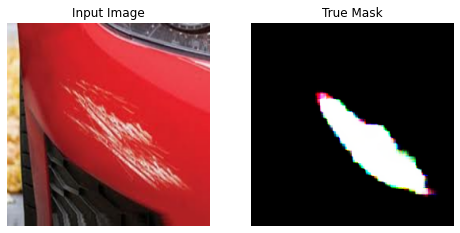

In [165]:
show_predictions(file_path)